## Lab 6

#### Prep Work

a) 

$I = \int_a^bf(x)dx$ 

$f(x) = 20 - x^2$

$I = \int_a^b(20 - x^2)dx$

$I = \left[20x - x^3/3\right]_a^b$

$I = 20(b-a) - \frac{1}{3}(b^3 - a^3)$



b)

In [97]:
def f(x: float) -> float:
    return (20 - x**2)

c)

In [98]:
def I(a: float, b: float) -> float:
    return 20*(b - a) - (b**3 - a**3)/3


#### Basic Monte Carlo

a)

The expectation of the estimator I is:

E[I] = $\frac{1}{n} \sum\limits_{i=1}^n E\left[\frac{f(X_i)}{p(X_i)}\right]$


E[I] = $\frac{1}{n} \sum\limits_{i=1}^n \int_{a}^{b} \frac{f(x)}{p(x)} p(x) dx$

The constant 1/(b-a) cancels out, giving:

E[I] = $\frac{1}{n} \sum\limits_{i=1}^n \int_{a}^{b} f(x) dx$

E[I] = $\int_{a}^{b} f(x) dx$

Substituting $f(x) = 20 - x^2$:

E[I] = $\int_{a}^{b} (20 - x^2) dx$

E[I] = $\left[20x - \frac{x^3}{3}\right]_{a}^{b}$

E[I] = $20b - \frac{b^3}{3} - (20a - \frac{a^3}{3})$

Simplifying:

E[I] = $20(b-a) - \frac{1}{3}(b^3 - a^3)$

b)

In [99]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from typing import Callable, Tuple

def mc_basic(f: Callable[[float], float], a: float, b: float, n: int) -> tuple[float, float]:
    
    p = 1 / (b - a)
    
    # Generate uniform random samples in [a,b]
    x = np.random.uniform(a, b, n)
    
    # Compute f(x)/p(x)
    integrand = f(x) / p
    
    integral_estimate = np.mean(integrand)
    
    variance_estimate = np.var(integrand) / n
    
    return integral_estimate, variance_estimate

c)

The variance of the estimator is given by:

$\operatorname{Var}(I_n^{\text{Basic}}) = \frac{1}{n} \left[ \mathbb{E}[g(X)^2] - \mathbb{E}[g(X)]^2 \right]$

Where $g(X) = \frac{f(X)}{p(X)}$ and $p(X) = \frac{1}{b-a}$

First, calculate $\mathbb{E}[g(X)]$:

$\mathbb{E}[g(X)] = \int_a^b \frac{f(x)}{p(x)} p(x) dx = \int_a^b f(x) dx$

$= \left[20x - \frac{x^3}{3}\right]_a^b$

$= 20(b-a) - \frac{1}{3}(b^3 - a^3)$

Next, calculate $\mathbb{E}[g(X)^2]$:

$\mathbb{E}[g(X)^2] = \int_a^b \frac{f(x)^2}{p(x)^2} p(x)dx$

$= \int_a^b \frac{(20 - x^2)^2}{p(x)} dx$

$= \int_a^b (b-a)(400 - 40x^2 + x^4) dx$

$= (b-a)\left[400x - \frac{40x^3}{3} + \frac{x^5}{5}\right]_a^b$

Finally, substituting $\frac{1}{n}[\mathbb{E}[g(X)^2] + \mathbb{E}[g(X)]^2]$

$\operatorname{Var}(I_n^{\text{Basic}}) = \frac{1}{n} \left[(b-a) \left(400(b-a) - \frac{40(b^3 - a^3)}{3}+ \frac{b^5 - a^5}{5} \right)- \left(20(b-a)- \frac{(b^3 - a^3)}{3}\right)^2 \right]$

d) 

In [100]:
def mc_basic_variance_true(a: float, b: float, n: int):
    # Define the integrals
    f_squared_integral = (b - a) * (400 * (b - a) - (40 * (b**3 - a**3) / 3) + (b**5 - a**5) / 5)
    f_integral = 20 * (b - a) - (b**3 - a**3) / 3
    f_integral_squared = f_integral**2
    
    # Compute the variance
    variance = (1 / n) * (f_squared_integral - f_integral_squared)
    return variance

e)

In [101]:
# Parameters
a, b = -1, 3
n = 100_000

# Compute metrics
integral_true = I(a, b)
integral_estimate, variance_estimate = mc_basic(f, a, b, n)
difference = abs(integral_true - integral_estimate)
sigma_squared_estimate = variance_estimate * n
sigma_squared_true = mc_basic_variance_true(a, b, n)
sigma_squared_true_normalized = sigma_squared_true / n

# Create DataFrame
results = pd.DataFrame({"Metric": ["integral_true","integral_estimate", "difference", "sigma^2_estimate/n", "sigma^2_estimate", "sigma^2_true/n", "sigma^2_true"],
    "Value": [ integral_true, integral_estimate, difference, variance_estimate, sigma_squared_estimate, sigma_squared_true_normalized, sigma_squared_true]})

print(results)


               Metric         Value
0       integral_true  7.066667e+01
1   integral_estimate  7.065893e+01
2          difference  7.738929e-03
3  sigma^2_estimate/n  1.083616e-03
4    sigma^2_estimate  1.083616e+02
5      sigma^2_true/n  1.080889e-08
6        sigma^2_true  1.080889e-03


#### Antithetic Uniform Samples

a)

First, let's understand the antithetic estimator:

$[\begin{aligned}
I_n^{\text{Antithetic}} &= \frac{1}{n/2} \sum\limits_{i=1}^{n/2} \frac12 \left(\frac{f(x_i)}{p(x_i)} + \frac{f(\hat x_i)}{p(\hat x_i)} \right) \
\text{where } p(x) &= \frac{1}{b-a}, \quad x_i \sim U[a,b]
\end{aligned}]$

Taking the expectation:

$[\begin{aligned}
\mathbb{E}^p[I_n^{\text{Antithetic}}] &= \frac{1}{n/2} \sum\limits_{i=1}^{n/2} \frac12 \left(\mathbb{E}^p\left[\frac{f(x_i)}{p(x_i)}\right] + \mathbb{E}^p\left[\frac{f(\hat x_i)}{p(\hat x_i)}\right]\right) \
&= \frac{1}{n/2} \sum\limits_{i=1}^{n/2} \frac{1}{2} \left(\int_a^b \frac{f(x)}{p(x)} p(x) dx + \int_a^b \frac{f(x)}{p(x)} p(x) dx\right) \
&= \int_a^b f(x) dx
\end{aligned}]$

b)

In [102]:
def mc_antithetic(f: Callable[[float], float], a: float, b: float, n: int):
    # Generate n/2 uniform random samples in [a, b]
    n_half = n // 2
    x = np.random.uniform(a, b, n_half)
    
    # Compute antithetic samples
    x_antithetic = a + b - x
    
    # Uniform PDF over [a, b]
    p = 1 / (b - a)
    
    # Compute the integral estimate
    integrand = 0.5 * (f(x) / p + f(x_antithetic) / p)
    integral_estimate = np.mean(integrand)
    
    # Compute variance
    variance_estimate = np.var(integrand) / n
    
    return integral_estimate, variance_estimate


c)

In [103]:
a, b, n = -1, 3, 100000

# Compute true integral
integral_true = I(a, b)

# Compute antithetic integral estimate
integral_estimate, variance_estimate = mc_antithetic(f, a, b, n)

# Metrics
difference = abs(integral_true - integral_estimate)
sigma_squared_estimate = variance_estimate * n

# Create DataFrame
results = pd.DataFrame({
    "Metric": ["integral_true", "integral_estimate", "difference", "sigma^2_estimate/n", "sigma^2_estimate"],
    "Value": [integral_true, integral_estimate, difference, variance_estimate, sigma_squared_estimate]
})

print(results)

               Metric      Value
0       integral_true  70.666667
1   integral_estimate  70.687549
2          difference   0.020882
3  sigma^2_estimate/n   0.000229
4    sigma^2_estimate  22.872557


d)

The antithetic method has less variance as compared to basic Monte Carlo method. This is because the antithetic method uses negative correlation between f(x) & f'(x) which leads to the reduction of errors.

#### Control Variate

a)


The control variate estimator is given as:

$[I_n^{\text{ControlVariate}} = \frac{1}{n} \sum_{i=1}^n \frac{f(x_i) - h(x_i)}{p(x_i)} + H]$
where $p(x) \sim U[a, b]$.

Since $x_i \sim U[a, b]$, the expected value of the estimator becomes:

$[\mathbb{E}^p[I_n^{\text{ControlVariate}}] = \mathbb{E}^p \left[ \frac{1}{n} \sum_{i=1}^n \frac{f(x_i)}{p(x_i)} \right] - \mathbb{E}^p \left[ \frac{1}{n} \sum_{i=1}^n \frac{h(x_i)}{p(x_i)} \right] + H]$

item From the property of uniform sampling:

$[\mathbb{E}^p \left[\frac{f(x_i)}{p(x_i)}\right] = \int_a^b f(x) dx]$

Similarly: 

$[\mathbb{E}^p \left[\frac{h(x_i)}{p(x_i)}\right] = \int_a^b h(x) dx = H]$

Substituting, the expected value becomes: 

$[\mathbb{E}^p[I_n^{\text{ControlVariate}}] = \int_a^b f(x) dx - H + H = \int_a^b f(x) dx]$

Thus, $\mathbb{E}^p[I_n^{\text{ControlVariate}}]$ equals the true value of the integral.

b)

In [104]:
def h1(x):
    #Evaluates h1(x) = 20*cos(x/3)
    return 20 * np.cos(x / 3)

def h2(x):
    #Evaluates h2(x) = 20*sin(x/3)
    return 20 * np.sin(x / 3)

def H1(a, b):
    #Evaluates the integral H1(a, b) = ∫_a^b 20*cos(x/3) dx
    return 60 * (np.sin(b / 3) - np.sin(a / 3))

def H2(a, b):
    #Evaluates the integral H2(a, b) = ∫_a^b 20*sin(x/3) dx
    return -60 * (np.cos(b / 3) - np.cos(a / 3))

c)

In [105]:
def mc_control_variate(f: Callable[[float], float], a: float, b: float, n: int, h: Callable[[float], float], H: Callable[[float, float], float]) -> Tuple[float, float]:
    # Generate random samples
    x_samples = np.random.uniform(a, b, n)
    p_x = 1 / (b - a)  # Uniform PDF
    # Compute the control variate-adjusted terms
    estimates = (f(x_samples) - h(x_samples)) / p_x
    integral_estimate = np.mean(estimates) + H(a, b)
    variance_estimate = np.var(estimates, ddof=1)
    return integral_estimate, variance_estimate

d)

In [106]:
a, b, n = -1, 3, 100000

# True value of the integral
integral_true = I(a, b)

# Estimate using h1 and h2
integral_h1, var_h1 = mc_control_variate(f, a, b, n, h1, H1)
integral_h2, var_h2 = mc_control_variate(f, a, b, n, h2, H2)

# Compute the required metrics
metrics = {
    "Metric": ["integral_true", "integral_estimate", "difference", "sigma^2_estimate/n", "sigma^2_estimate"],
    "h1": [integral_true, integral_h1, integral_h1 - integral_true, var_h1, var_h1 * n,],
    "h2": [integral_true, integral_h2, integral_h2 - integral_true, var_h2, var_h2 * n,],
}

# Create a pandas DataFrame
df = pd.DataFrame(metrics)
print(df)

               Metric            h1            h2
0       integral_true     70.666667  7.066667e+01
1   integral_estimate     70.665297  7.075065e+01
2          difference     -0.001370  8.398237e-02
3  sigma^2_estimate/n      0.202407  1.378591e+03
4    sigma^2_estimate  20240.698813  1.378591e+08


e)

We can conclude this on the basis of two factors:

1) Difference between intergral_true & intergral_estimate values 

2) Variance or sigma^2_estimate/n values

Upon comparison we can see sigma^2_estimate/n is least for h1, hence h1 is the better estimate 

f)

The control variate method aims to reduce variance compared to basic Monte Carlo integration. The variance reduction depends on how well the control variate correlates with the original function. We cans ee this from the graph below.

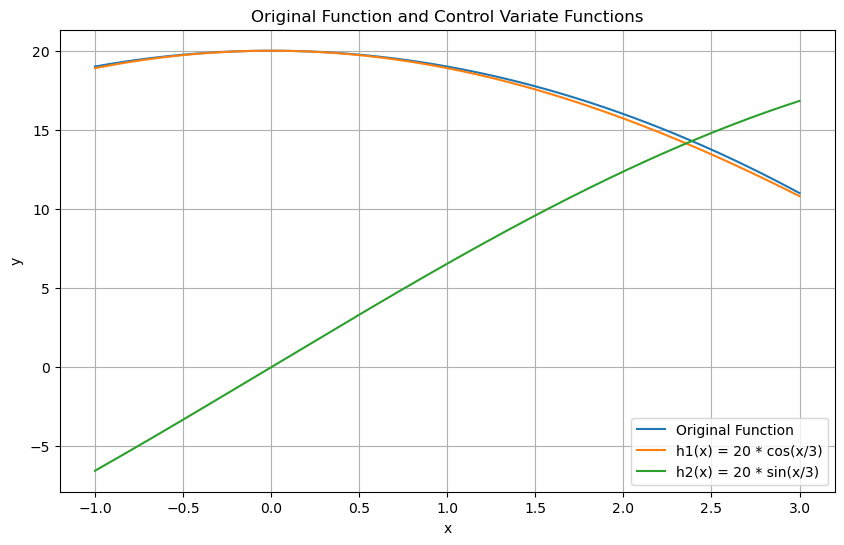

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
x = np.linspace(-1, 3, 200)
plt.plot(x, f(x), label='Original Function')
plt.plot(x, h1(x), label='h1(x) = 20 * cos(x/3)')
plt.plot(x, h2(x), label='h2(x) = 20 * sin(x/3)')
plt.title('Original Function and Control Variate Functions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

#### Importance Sampling

a)

The importance sampling estimator is given by:

$I_n^{\text{Importance}} = \frac{1}{n} \sum_{i=1}^n \frac{f(x_i)}{p(x_i)}$

where $p(x_i)$ is the normal distribution $\mathcal{N}(\mu, \sigma)$, and $f(x_i)$ is the function we're integrating.

The expectation of this estimator is:

$\mathbb{E}^p[I_n^{\text{Importance}}] = \int_a^b \frac{f(x)}{p(x)} p(x) dx = \int_a^b f(x) dx$

b)

In [108]:
def mc_importance(f, a, b, n, sigma):
    # Draw n samples from a normal distribution with mean=0, std=sigma
    x_samples = np.random.normal(loc=0, scale=sigma, size=n)

    # Keep only those that fall within the interval [a, b]
    valid_samples = x_samples[(x_samples >= a) & (x_samples <= b)]

    # Adjust the sample size after filtering
    n_used = len(valid_samples)

    # Calculate the importance sampling estimator
    weights = f(valid_samples) / norm.pdf(valid_samples, 0, sigma)
    importance_estimate = np.mean(weights)

    # Estimate the variance of the estimator
    variance_estimate = np.var(weights) / n_used

    return importance_estimate, variance_estimate, n_used

c)

In [109]:

sigma_values = np.arange(1, 11)

results = []

for sigma in sigma_values:
    integral_true = I(-1, 3)  # True integral over [-1, 3]
    integral_estimate, variance_estimate, n_used = mc_importance(f, -1, 3, 100000, sigma)
    
    # Compute the difference and other metrics
    difference = abs(integral_estimate - integral_true)
    sigma_squared_estimate = variance_estimate * 100000
    
    results.append({
        'sigma': sigma,
        'integral_true': integral_true,
        'integral_estimate': integral_estimate,
        'difference': difference,
        'sigma^2_estimate/n': variance_estimate,
        'sigma^2_estimate': sigma_squared_estimate,
        'n_used': n_used
    })

# Create DataFrame to display results
df = pd.DataFrame(results)
print(df)

   sigma  integral_true  integral_estimate  difference  sigma^2_estimate/n  \
0      1      70.666667          83.476737   12.810070            0.152851   
1      2      70.666667         113.196034   42.529367            0.004697   
2      3      70.666667         149.745006   79.078339            0.000154   
3      4      70.666667         189.926821  119.260154            0.005136   
4      5      70.666667         231.825387  161.158721            0.017196   
5      6      70.666667         274.246789  203.580123            0.037658   
6      7      70.666667         317.685556  247.018890            0.067664   
7      8      70.666667         361.403113  290.736446            0.109273   
8      9      70.666667         404.528383  333.861717            0.161946   
9     10      70.666667         447.705088  377.038422            0.235657   

   sigma^2_estimate  n_used  
0      15285.121713   84054  
1        469.743032   62551  
2         15.359386   47057  
3        513.585133  

d)

From the generated DataFrame and plots, we can say:

1) The smallest difference from the true integral suggests the most accurate estimator

2) A low variance estimate indicates more consistent sampling

3) The number of used samples also plays a role in the estimator's reliability

the graphs below suggest that estimate 2 and 3 provides the best trade off comapred to others and is a better estimate

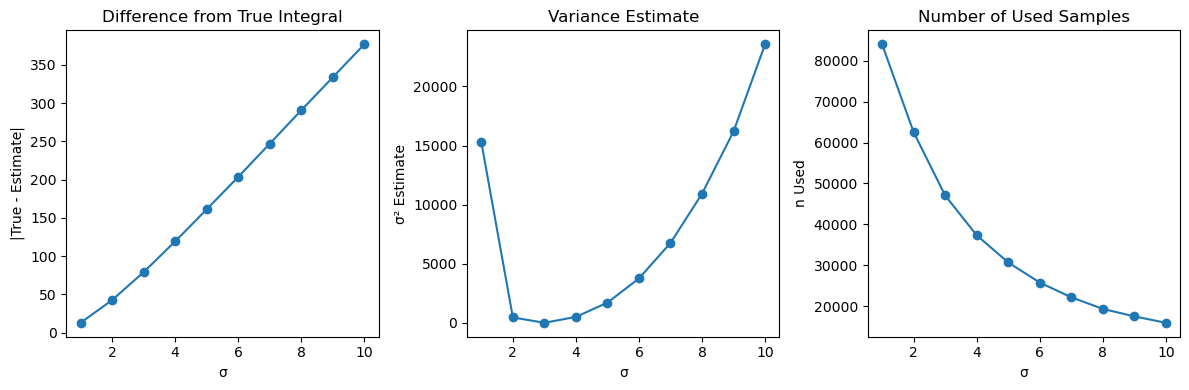

In [110]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot 1: Difference from True Integral
plt.subplot(1, 3, 1)
plt.plot(df['sigma'], df['difference'], marker='o')
plt.title('Difference from True Integral')
plt.xlabel('σ')
plt.ylabel('|True - Estimate|')

# Plot 2: Variance Estimate
plt.subplot(1, 3, 2)
plt.plot(df['sigma'], df['sigma^2_estimate'], marker='o')
plt.title('Variance Estimate')
plt.xlabel('σ')
plt.ylabel('σ² Estimate')

# Plot 3: Number of Used Samples
plt.subplot(1, 3, 3)
plt.plot(df['sigma'], df['n_used'], marker='o')
plt.title('Number of Used Samples')
plt.xlabel('σ')
plt.ylabel('n Used')

plt.tight_layout()
plt.show()

e)

Upon comparison with basic estimate, importance sampling estimate provides:

1) More efficient sampling with close value to true estimate

2) Lower variance as we can see in the table above 

3) More accurate estimates compared to uniform sampling


f)

As the standard deviation (σ) increases, the normal distribution becomes wider and flatter, causing fewer samples to fall within the specific [-1, 3] interval. This occurs due to the probability nature of sampling from a broader distribution, where the probability of drawing a sample in the target range decreases. So a larger σ spreads out the samples more thinly, requiring more total draws to obtain the same number of samples within the desired interval, hence reducing the efficiency of the importance sampling method.